In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import os

In [8]:
hourly_input = '../../DATA/rainfall/hourly_gauges_SIATA_EPM/'


hourly_files = sorted(glob(hourly_input + 'H_Datos_Procesados_Est_*.csv'))

stations_with_paths = [
    (int(os.path.basename(file).split('_')[-1].split('.')[0]), file) 
    for file in hourly_files]

stations_with_paths_sorted = sorted(stations_with_paths, key=lambda x: x[0])

# Filtra las estaciones de SIATA excluyendo las estaciones de EPM (últimas 16)
siata_stations_with_paths = stations_with_paths_sorted[:]


siata_hourly_files = [station[1] for station in siata_stations_with_paths]

#Cargar y Renombrar Datos de las Estaciones
data_frames = []
station_numbers = []

for station_number, file in siata_stations_with_paths:
    station_data = pd.read_csv(file, index_col='Fecha', parse_dates=True)
    
    # Verifica y elimina la columna 'Unnamed: 0' si existe
    if 'Unnamed: 0' in station_data.columns:
        station_data = station_data.drop(columns=['Unnamed: 0'])
    
    if 'P' in station_data.columns:
        station_data.rename(columns={'P': f'Est_{station_number}'}, inplace=True)
    else:
        precip_column = [col for col in station_data.columns if 'P' in col.upper()]
        if precip_column:
            station_data.rename(columns={precip_column[0]: f'Est_{station_number}'}, inplace=True)
        else:
            print(f"Advertencia: No se encontró columna de precipitación en {file}")
            continue
    
    data_frames.append(station_data)
    station_numbers.append(station_number)

all_stations_df = pd.concat(data_frames, axis=1, join='outer')

In [3]:
# Dejar estaciones con 10 o más años de datos
min_hours = 10 * 365 * 24  # ~87,600

# Filtra columnas (estaciones) que tengan al menos 'min_hours' datos válidos (no nulos)
all_stations_df_10y = all_stations_df.loc[:, all_stations_df.count() >= min_hours]

# Filtrar filas desde '2013-01-01' hasta el final de las series
all_stations_df_10y = all_stations_df_10y.loc['2012-01-01':]

# Mostrar la cantidad de datos faltantes por estación
missing_values = all_stations_df_10y.isna().sum()
total_days = len(all_stations_df_10y)
missing_percentage = (missing_values / total_days) * 100


# 1. Creamos el DataFrame con ambas series
df_missing = pd.DataFrame({
    'Datos_faltantes': missing_values,
    'Porcentaje_NaN': missing_percentage
})

# 2. Redondear el porcentaje a 2 decimales
df_missing['Porcentaje_NaN'] = df_missing['Porcentaje_NaN'].round(2)

In [4]:
def imputar_nan_horario_por_hora(df, limit=24):
    """
    Rellena los valores NaN en un DataFrame de series temporales horarias.
    
    1. Interpola valores ausentes de hasta 'limit' horas consecutivas.
    2. Rellena los NaN restantes con la media de esa hora del día (0 a 23).

    Args:
        df (pd.DataFrame): 
            DataFrame con índice de tipo fecha (frecuencia horaria) y 
            columnas correspondientes a distintas series (por ejemplo, estaciones).
        limit (int):
            Límite de horas consecutivas a interpolar. Por defecto 24.
    
    Returns:
        pd.DataFrame: DataFrame con los NaN imputados.
    """
    df_imputado = df.copy()
    
    # Paso 1: Interpolar huecos de hasta 'limit' horas consecutivas
    df_imputado = df_imputado.interpolate(method='time', limit=limit, limit_direction='both')
    
    # Paso 2: Rellenar los NaN restantes con la media por hora del día
    df_imputado['Hora'] = df_imputado.index.hour

    # Calculamos la media para cada hora (0-23)
    medias_por_hora = df_imputado.groupby('Hora').transform('mean')
    
    # Rellenamos los NaN con esos valores medios
    df_imputado = df_imputado.fillna(medias_por_hora)
    
    # Eliminamos la columna auxiliar
    df_imputado.drop(columns=['Hora'], inplace=True)
    
    return df_imputado

In [5]:
all_stations_df_10y_imputed = imputar_nan_horario_por_hora(all_stations_df_10y)

missing_values_2 = all_stations_df_10y_imputed.isna().sum()
total_days = len(all_stations_df_10y_imputed)
missing_percentage = (missing_values_2 / total_days) * 100


print("Porcentaje de datos faltantes (NaN) por estación:")
# 1. Creamos el DataFrame con ambas series
df_missing = pd.DataFrame({
    'Datos_faltantes': missing_values_2,
    'Porcentaje_NaN': missing_percentage
})

# 2. Redondear el porcentaje a 2 decimales
df_missing['Porcentaje_NaN'] = df_missing['Porcentaje_NaN'].round(2)


Porcentaje de datos faltantes (NaN) por estación:


In [9]:
# Load the dataset and convert 'Fecha' to datetime
#data = all_stations_df_10y_imputed
data = all_stations_df

# Calculate average correlations for each hour
average_correlations_by_hour = []
std_devs_by_hour = []
rows_greater_by_hour = []
rows_between_by_hour = []

# Loop through each hour of the day (0-23)
for hour in range(24):
    # Filter data for the specific hour
    hourly_data = data[data.index.hour == hour]
    
    # Drop columns where all values are NaN
    hourly_data_clean = hourly_data.dropna(axis=1, how='all')
    
    if hourly_data_clean.shape[1] > 1:  # Need at least two columns to compute correlation
        # Calculate Spearman correlation matrix
        correlation_matrix = hourly_data_clean.corr(method='spearman')
        
        # Extract the upper triangle of the correlation matrix without the diagonal
        upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
        
        # Calculate the mean and standard deviation of the non-NaN correlations in the upper triangle
        mean_correlation = upper_triangle.stack().mean()
        std_dev_correlation = upper_triangle.stack().std()
        
        # Append the results for this hour
        average_correlations_by_hour.append(mean_correlation)
        std_devs_by_hour.append(std_dev_correlation)
    else:
        average_correlations_by_hour.append(np.nan)
        std_devs_by_hour.append(np.nan)
    
    # Count rows where any station has values greater than 
    rows_greater = (hourly_data_clean > 15).sum().sum()
    rows_greater_by_hour.append(rows_greater)

    # Count rows where values are between (inclusive)
    rows_between = hourly_data_clean.apply(lambda x: x.between(1, 15)).sum().sum()
    rows_between_by_hour.append(rows_between)

# Rearrange the data to start from 6 AM and end at 6 AM
shifted_correlations = average_correlations_by_hour[6:] + average_correlations_by_hour[:6]
shifted_std_devs = std_devs_by_hour[6:] + std_devs_by_hour[:6]
shifted_rows_greater = rows_greater_by_hour[6:] + rows_greater_by_hour[:6]
shifted_rows_between = rows_between_by_hour[6:] + rows_between_by_hour[:6]

# Create corresponding x-axis labels to reflect the sequence from 6 AM to 5 AM
shifted_hours_labels = list(range(6, 24)) + list(range(0, 6))

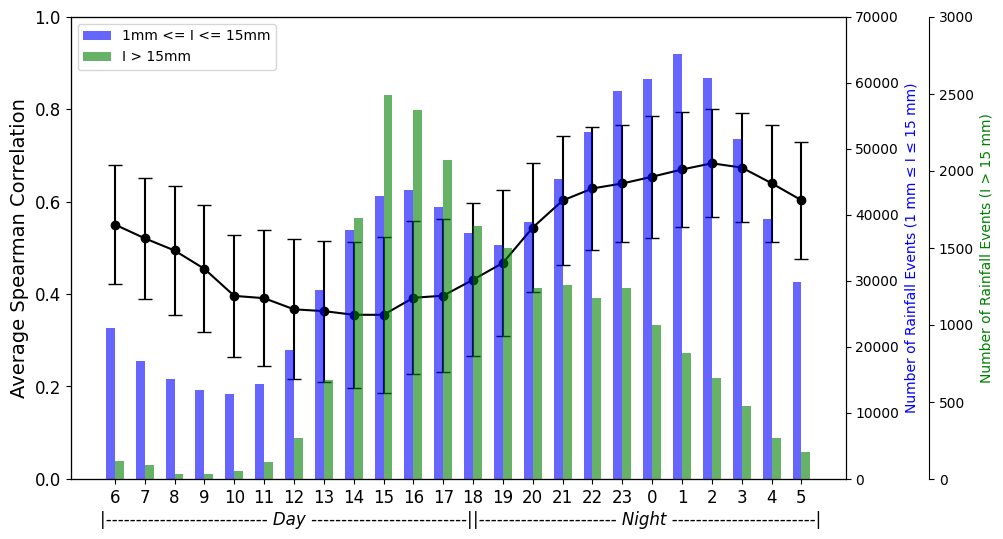

In [19]:
# Plot the data with error bars representing the standard deviation
fig, ax1 = plt.subplots(figsize=(10, 6))

# Line plot for Spearman correlations
ax1.errorbar(range(24), shifted_correlations, yerr=shifted_std_devs, fmt='o', linestyle='-', markersize=6, capsize=5, color='black')
#ax1.set_xlabel('Hour of Day', fontsize=14)
ax1.set_ylabel('Average Spearman Correlation', color='black',fontsize=14)
ax1.set_ylim(0, 1)
ax1.set_xticks(range(24))
ax1.set_xticklabels(shifted_hours_labels)
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.grid(False)


# Add the first right y-axis for rows between 1 and 10
ax2 = ax1.twinx()
width = 0.3  # Bar width

# Bar plot for rows with values between (blue)
ax2.bar(np.array(range(24)) - width/2, shifted_rows_between, width, alpha=0.6, color='blue', label='1mm <= I <= 15mm')
ax2.set_ylabel('Number of Rainfall Events (1 mm ≤ I ≤ 15 mm)', color='blue')
ax2.set_ylim(0, 70000)  # Set maximum y-axis limit to 20,000

# Add the second right y-axis for rows greater than
ax3 = ax1.twinx()

# Shift the second y-axis slightly to the right
ax3.spines['right'].set_position(('outward', 60))

# Bar plot for rows with values greater than (green)
ax3.bar(np.array(range(24)) + width/2, shifted_rows_greater, width, alpha=0.6, color='green', label='I > 15mm')
ax3.set_ylabel('Number of Rainfall Events (I > 15 mm)', color='green')
ax3.set_ylim(0, 3000)  # Set maximum y-axis limit

# Add legend to differentiate the bars
handles2, labels2 = ax2.get_legend_handles_labels()
handles3, labels3 = ax3.get_legend_handles_labels()
handles = handles2 + handles3
labels = labels2 + labels3
ax1.legend(handles, labels, loc='upper left')

# Add lines on the top and right sides to close the figure (without labels or ticks)
ax1.spines['top'].set_visible(True)
ax1.spines['right'].set_visible(True)
ax1.spines['top'].set_color('black')
ax1.spines['right'].set_color('black')

# Hide ticks and labels on top and right axes
ax1.tick_params(top=False, right=False)

ax1.text(-0.5, -0.1, '|--------------------------- Day --------------------------|', style ='italic', fontsize = 12, )
ax1.text(12, -0.1, '|----------------------- Night ------------------------|', style ='italic', fontsize = 12, )

# Save the figure as PNG
plt.savefig('../../FIGURES/spatial_analysis/spearman_correlation.png', format='png', dpi=500, bbox_inches='tight')

# Show the plot
#plt.show()
